# Using Genestack Omics APIs for single-cell analysis

This notebook demonstrates the scalability of the Omics APIs in querying and getting thousands of single-cell samples and expression values.

The dataset used is [GSE120575](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE120575), from Sade-Feldman et al., ["Defining T Cell States Associated with Response to Checkpoint Immunotherapy in Melanoma"](https://www.ncbi.nlm.nih.gov/pubmed/30388456), 2018. It has **16,291 individual immune cells from 48 tumor samples** of melanoma patients treated with checkpoint inhibitors.

Example queries are provided to get:
- A subset of samples that correspond to CD8+ cells (**8,331 samples**)
- The expression values of the gene TCF7 across CD8+ cells

Two plots are produced:
- The expression distribution of TCF7 across CD8+ cells
- The association of patient response with TCF7 expression among CD8+ cells

### 1. Connect to the instance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, time
# Genestack client library
import integration_curator

os.environ['PRED_SPOT_HOST'] = 'occam.genestack.com'
os.environ['PRED_SPOT_TOKEN'] = '<your API token>'
os.environ['PRED_SPOT_VERSION'] = '<API version>'
page_limit = 20000

omics_api = integration_curator.OmicsQueriesApi()

### 2. Get a subset of samples that correspond to CD8+ cells

In [2]:
study_filter = '"%s"="%s"' % ('Study Source ID', 'GSE120575')
cell_filter = ' OR '.join(['"Cluster number"="%s"' % cluster for cluster in [5, 8, 10, 9, 11]])

start = time.time()
samples = omics_api.search_samples(
    study_filter = study_filter,
    sample_filter = cell_filter,
    page_limit = page_limit
)
samples = pd.DataFrame.from_dict([item['metadata'] for item in samples.data])

print 'Time to get %s samples: %s seconds' % (samples.shape[0], round(time.time()-start))

Time to get 8331 samples: 19.0 seconds


### 3. Get the expression values of the gene TCF7 across CD8+ cells

In [3]:
gene = 'TCF7'
expression_filter = 'Gene=%s MinValue=0.0' % gene

start = time.time()
expressions = omics_api.search_expression_data(
    study_filter = study_filter,
    sample_filter = cell_filter,
    ex_query = expression_filter,
    page_limit = page_limit
)
expressions = pd.DataFrame.from_dict({'genestack:accession': item['relationships']['sample'], 
                                      'expression': item['expression'],
                                      'gene': item['gene']} for item in expressions.data)

print 'Time to get %s expression values: %s seconds' % (expressions.shape[0], round(time.time()-start))

Time to get 8331 expression values: 18.0 seconds


### 4. Expression distribution of TCF7 across CD8+ cells

Text(0.5,1,'Expression of TCF7 across CD8+ cells')

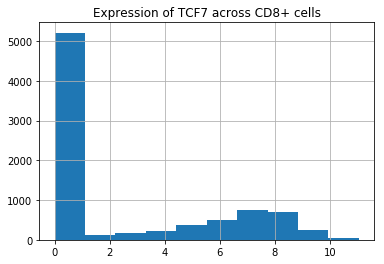

In [4]:
expressions[['expression']].hist()
plt.title('Expression of %s across CD8+ cells' % gene)

### 5. Association of patient response with TCF7 expression among CD8+ cells

Text(0.5,1,'Proportion of CD8+ cells that express TCF7 (per donor)')

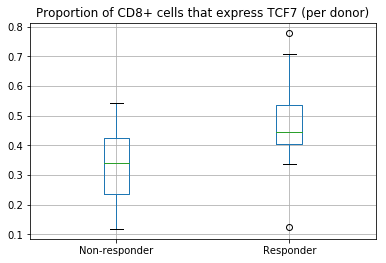

In [5]:
expression_threshold = 2
samples_expressions = pd.merge(samples, expressions)
samples_expressions['expressed'] = samples_expressions['expression'].apply(lambda x: 1 if x > expression_threshold else 0)
group = 'characteristics: response'
samples_expressions.groupby(['Donor ID', group]).mean().boxplot('expressed', group)
plt.suptitle('')
plt.xlabel('')
plt.title('Proportion of CD8+ cells that express %s (per donor)' % gene)